# Model Training

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
df = pd.read_csv('./data/Preprocessed_StudentsPerformance.csv')
df.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
913,female,group C,bachelor's degree,free/reduced,completed,47,62,66,175,58.33
101,male,group D,bachelor's degree,standard,completed,68,74,74,216,72.00
238,male,group B,some college,standard,none,54,52,51,157,52.33
546,female,group A,some high school,standard,completed,92,100,97,289,96.33
343,male,group D,associate's degree,standard,completed,67,72,67,206,68.67


## Preparing X and Y Variables

In [4]:
X = df.drop(columns=['total_score','average_score'])
y = df['average_score']

In [5]:
X.shape

(1000, 8)

In [6]:
y.shape

(1000,)

### Preprocess X: Create Column Transformer

* for features that have a not very large number of categories, one-hot encoding is a good choice
* for features that have a lot many categories, target-guided ordinal encoding could be a better option. 
    * in this type of encoding, for each category within the feature we calculate a statistic of the target variable (like mean, median, or sum) associated with that category;
    * then sort the categories based on the statistics in ascending/descending order, and assign numerical ranks to the categories. 
    * this reduces dimensionality of the data compared to one-hot encoding especially when there are a large number of unique categories for the feature. 
    * it also explicitly encodes a relationship between the feature and the target variable.

* ColumnTransformer is used for creating a pipeline
* we want to combine the one-hot encoding process of categorical features and standard scaling process of nunerical features, into a single pipeline

In [7]:
numerical_feat = X.select_dtypes(exclude="object").columns
categorical_feat = X.select_dtypes(include="object").columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", categorical_transformer, categorical_feat),
        ("StandardScaler", numerical_transformer, numerical_feat)
    ]
)

In [8]:
X_prepped = preprocessor.fit_transform(X)

In [9]:
X_prepped.shape

(1000, 20)

In [10]:
X_prepped[::500]

array([[1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.39002351, 0.19399858, 0.39149181],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.52198883, 0.67368424, 0.91822145]])

## Split for Training & Testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_prepped, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 20), (200, 20), (800,), (200,))

## Creating Evaluation Function

In [12]:
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r_square = r2_score(actual, predicted)
    return mae, rmse, r_square

## Defining All Models

In [26]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regression": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "XGB Regression": XGBRegressor(),
    "CatBoosting Regression": CatBoostRegressor(verbose=False),
    "AdaBoost Regression": AdaBoostRegressor()
}

def model_training(X_train, y_train, X_test, y_test):
    model_eval = {"model":[], "MAE":[], "RMSE":[], "R2_Score":[]}

    for i in range(len(models.items())):
        model = list(models.values())[i]
        
        # fit model
        model.fit(X_train, y_train)
        
        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # evaluate model
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        model_eval['model'].append(list(models.keys())[i])
        model_eval['MAE'].append(np.round(model_test_mae,4))
        model_eval['RMSE'].append(np.round(model_test_rmse,4))
        model_eval['R2_Score'].append(np.round(model_test_r2,4))
        
    return pd.DataFrame(model_eval)
    

In [28]:
model_evals = model_training(X_train, y_train, X_test, y_test)

In [29]:
model_evals

,model,MAE,RMSE,R2_Score
0,Linear Regression,0.0022,0.0026,1.0000
1,Lasso,0.8769,1.1143,0.9942
2,Ridge,0.0073,0.0094,1.0000
3,K-Neighbors Regression,2.2834,3.0706,0.9560
4,Decision Tree,1.1432,1.6305,0.9876
5,Random Forest Regression,0.5097,1.1236,0.9941
6,XGB Regression,0.5722,1.0754,0.9946
7,CatBoosting Regression,0.3413,1.1623,0.9937
8,AdaBoost Regression,1.5002,2.1254,0.9789


In [30]:
model_evals.describe()

,MAE,RMSE,R2_Score
count,9.000000,9.000000,9.000000
mean,0.804044,1.257122,0.988789
std,0.743786,0.961307,0.013879
min,0.002200,0.002600,0.956000
25%,0.341300,1.075400,0.987600
50%,0.572200,1.123600,0.994100
75%,1.143200,1.630500,0.994600
max,2.283400,3.070600,1.000000


In [46]:
min_mae_model = model_evals[model_evals['MAE']==model_evals['MAE'].min()]['model'].values
min_rmse_model = model_evals[model_evals['RMSE']==model_evals['RMSE'].min()]['model'].values
max_r2_model = model_evals[model_evals['R2_Score']==model_evals['R2_Score'].max()]['model'].values

In [47]:
print(min_mae_model)
print(min_rmse_model)
print(max_r2_model)

['Linear Regression']
['Linear Regression']
['Linear Regression' 'Ridge']


* We will proceed with the Linear Regression Model as it has the least mean-absolute error, least root-mean-squared error, and highest R-squared score

## Linear Regression

In [50]:
linReg = LinearRegression()
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)
print(r2_score(y_test, y_pred))

0.9999999672774438


### Plot Actual vs Predicted

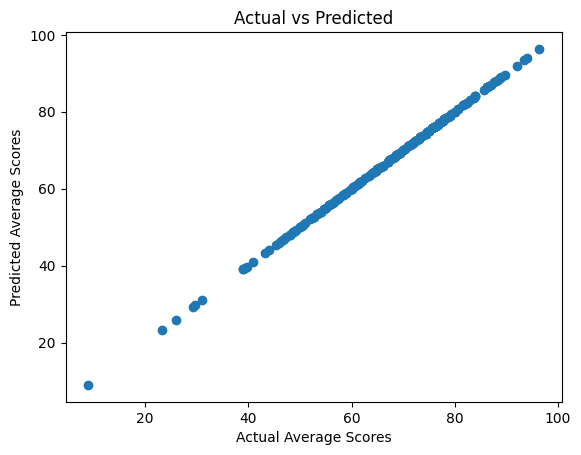

In [52]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Average Scores")
plt.ylabel("Predicted Average Scores")
plt.title("Actual vs Predicted")
plt.show()

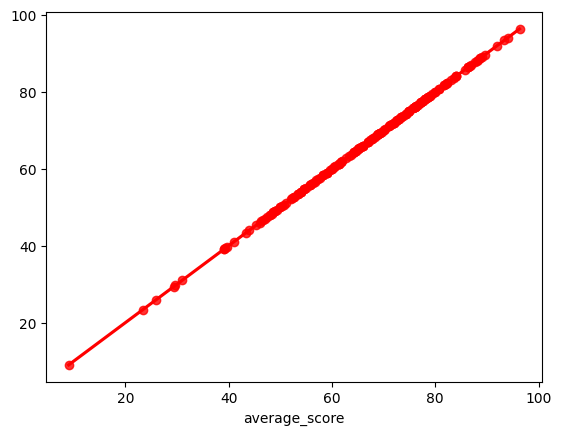

In [58]:
sns.regplot(x=y_test, y=y_pred,color='red')
plt.show()

In [60]:
linRegModel = pd.DataFrame(data={'actual_values':y_test, 'predicted_values':y_pred,'residual':y_test-y_pred})
linRegModel.sample(20)

,actual_values,predicted_values,residual
845,86.33,86.332560,-0.002560
901,75.00,75.000087,-0.000087
429,61.67,61.666185,0.003815
522,61.33,61.334096,-0.004096
235,77.33,77.333247,-0.003247
309,52.67,52.667462,0.002538
714,68.00,67.999914,0.000086
787,29.67,29.666448,0.003552
570,72.00,71.999602,0.000398
120,86.67,86.667082,0.002918
